# # Neural Sentinel: Data Preprocessing
# 
# This notebook handles:
# 1. Loading NSL-KDD and UNSW-NB15 datasets
# 2. Data cleaning (missing values, duplicates)
# 3. Feature engineering
# 4. Data balancing using Optimized SMOTE
# 5. Sequence formation for Bi-LSTM
# 6. Train/test splitting
# 7. Data export for model training


In [42]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install requirements
    !pip install -q imbalanced-learn pandas numpy scikit-learn matplotlib seaborn
    
    # Set project root
    PROJECT_ROOT = '/content/drive/MyDrive/neural-sentinel'
else:
    print("💻 Running locally")
    PROJECT_ROOT = os.getcwd()

print(f"📁 Project root: {PROJECT_ROOT}")

💻 Running locally
📁 Project root: c:\Other files\GitHub\neural-sentinel


In [43]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import json

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

1. Dataset Loading

In [44]:
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print(f"📂 Raw data directory: {RAW_DATA_DIR}")
print(f"📂 Processed data directory: {PROCESSED_DATA_DIR}")

# NSL-KDD column names (41 features + label)
nsl_kdd_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
    'difficulty_level'
]

# UNSW-NB15 will be auto-detected from CSV headers

def load_nsl_kdd(train_path, test_path):
    """Load NSL-KDD dataset"""
    
    # Load train and test
    train_df = pd.read_csv(train_path, names=nsl_kdd_columns)
    test_df = pd.read_csv(test_path, names=nsl_kdd_columns)
    
    # Remove difficulty level column
    train_df = train_df.drop('difficulty_level', axis=1)
    test_df = test_df.drop('difficulty_level', axis=1)
    
    print(f"  ✅ Train: {train_df.shape[0]:,} records")
    print(f"  ✅ Test: {test_df.shape[0]:,} records")
    
    return train_df, test_df

def load_unsw_nb15(train_path, test_path):
    """Load UNSW-NB15 dataset"""
    print("📊 Loading UNSW-NB15 dataset...")
    
    # Load with automatic header detection
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    print(f"  ✅ Train: {train_df.shape[0]:,} records")
    print(f"  ✅ Test: {test_df.shape[0]:,} records")
    print(f"  ✅ Features: {train_df.shape[1]}")
    
    return train_df, test_df

📂 Raw data directory: c:\Other files\GitHub\neural-sentinel\data\raw
📂 Processed data directory: c:\Other files\GitHub\neural-sentinel\data\processed


In [45]:
print("⚠️  Place your datasets in the following locations:")
print(f"   NSL-KDD Train: {RAW_DATA_DIR}/KDDTrain+.txt")
print(f"   NSL-KDD Test: {RAW_DATA_DIR}/KDDTest+.txt")
print(f"   UNSW-NB15 Train: {RAW_DATA_DIR}/UNSW_NB15_training-set.csv")
print(f"   UNSW-NB15 Test: {RAW_DATA_DIR}/UNSW_NB15_testing-set.csv")

⚠️  Place your datasets in the following locations:
   NSL-KDD Train: c:\Other files\GitHub\neural-sentinel\data\raw/KDDTrain+.txt
   NSL-KDD Test: c:\Other files\GitHub\neural-sentinel\data\raw/KDDTest+.txt
   UNSW-NB15 Train: c:\Other files\GitHub\neural-sentinel\data\raw/UNSW_NB15_training-set.csv
   UNSW-NB15 Test: c:\Other files\GitHub\neural-sentinel\data\raw/UNSW_NB15_testing-set.csv


2. Data Cleaning

In [46]:
def clean_data(df, dataset_name):
    """
    Clean dataset according to research paper methodology:
    - Remove missing values
    - Remove duplicates
    - Handle inconsistent data
    """
    
    initial_shape = df.shape
    print(f"  Initial shape: {initial_shape}")
    
    # 1. Handle missing values
    missing_before = df.isnull().sum().sum()
    if missing_before > 0:
        print(f"  ⚠️  Found {missing_before} missing values")
        # Drop rows with missing values
        df = df.dropna()
        print(f"  ✅ Removed rows with missing values")
    
    # 2. Remove duplicates
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  ⚠️  Found {duplicates} duplicate rows")
        df = df.drop_duplicates()
        print(f"  ✅ Removed duplicate rows")
    
    # 3. Remove constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        print(f"  ⚠️  Found {len(constant_cols)} constant columns")
        df = df.drop(constant_cols, axis=1)
        print(f"  ✅ Removed constant columns: {constant_cols}")
    
    final_shape = df.shape
    print(f"  Final shape: {final_shape}")
    print(f"  📉 Removed: {initial_shape[0] - final_shape[0]:,} rows")
    
    return df

3. Feature Engineering

In [47]:
def encode_categorical_features(df):
    """Encode categorical features using Label Encoding"""
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    if len(categorical_cols) > 0:
        print(f"  🔢 Encoding {len(categorical_cols)} categorical features...")
        
        encoders = {}
        for col in categorical_cols:
            if col not in ['attack_type', 'label']:  # Don't encode target
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                encoders[col] = le
        
        return df, encoders
    
    return df, {}

def normalize_features(X_train, X_test):
    """Normalize features using StandardScaler"""
    print("  📊 Normalizing features...")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

def prepare_labels(df, label_col='label'):
    """
    Prepare binary labels (Normal=0, Attack=1)
    """
    if label_col in df.columns:
        # If already binary
        if df[label_col].nunique() == 2:
            return df
        
        # Convert attack types to binary
        df[label_col] = (df[label_col] != 'normal').astype(int)
    
    elif 'attack_type' in df.columns:
        df['label'] = (df['attack_type'] != 'normal').astype(int)
        df = df.drop('attack_type', axis=1)
    
    return df

4. Data Balancing (Optimized SMOTE)

In [48]:
def apply_optimized_smote(X, y, sampling_strategy='auto', k_neighbors=5):
    """
    Apply SMOTE as described in the research paper
    
    Parameters:
    - sampling_strategy: ratio of minority class to generate
    - k_neighbors: number of nearest neighbors for synthetic sample generation
    """
    print("\n⚖️  Applying Optimized SMOTE...")
    
    print(f"  Before SMOTE: {Counter(y)}")
    
    # Apply SMOTE
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors,
        random_state=42
    )
    
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print(f"  After SMOTE: {Counter(y_resampled)}")
    print(f"  📈 Generated {len(X_resampled) - len(X):,} synthetic samples")
    
    return X_resampled, y_resampled

5. Sequence Formation for Bi-LSTM

In [49]:
def create_sequences(X, y, sequence_length=10, stride=1):
    """
    Create sequential windows for Bi-LSTM input
    
    Parameters:
    - sequence_length: number of time steps (packets) per sequence
    - stride: step size for sliding window
    
    Returns:
    - X_seq: shape (n_sequences, sequence_length, n_features)
    - y_seq: shape (n_sequences,) - label of last packet in sequence
    """
    print(f"\n🔄 Creating sequences (window={sequence_length}, stride={stride})...")
    
    X_seq = []
    y_seq = []
    
    for i in range(0, len(X) - sequence_length + 1, stride):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length-1])  # Label of last packet
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    print(f"  ✅ Created {len(X_seq):,} sequences")
    print(f"  Shape: {X_seq.shape}")
    
    return X_seq, y_seq

6. Complete Preprocessing Pipeline

In [50]:
def plot_class_distribution(y_before, y_after, dataset_name):
    """Plot class distribution before and after SMOTE"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before SMOTE
    before_counts = Counter(y_before)
    axes[0].bar(before_counts.keys(), before_counts.values(), color=['green', 'red'])
    axes[0].set_title(f'{dataset_name} - Before SMOTE')
    axes[0].set_xlabel('Class (0=Normal, 1=Attack)')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks([0, 1])
    
    # After SMOTE
    after_counts = Counter(y_after)
    axes[1].bar(after_counts.keys(), after_counts.values(), color=['green', 'red'])
    axes[1].set_title(f'{dataset_name} - After SMOTE')
    axes[1].set_xlabel('Class (0=Normal, 1=Attack)')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks([0, 1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROCESSED_DATA_DIR, f'{dataset_name}_class_dist.png'), dpi=300)
    plt.show()

In [51]:
def preprocess_dataset(train_df, test_df, dataset_name, 
                       sequence_length=10, apply_smote=True):
    """
    Complete preprocessing pipeline
    """
    print(f"\n{'='*60}")
    print(f"🚀 Processing {dataset_name} Dataset")
    print(f"{'='*60}")
    
    # Step 1: Clean data
    train_clean = clean_data(train_df.copy(), f"{dataset_name} Train")
    test_clean = clean_data(test_df.copy(), f"{dataset_name} Test")
    
    # Step 2: Prepare labels
    train_clean = prepare_labels(train_clean)
    test_clean = prepare_labels(test_clean)
    
    # Step 3: Separate features and labels
    label_col = 'label'
    X_train = train_clean.drop([label_col], axis=1, errors='ignore')
    y_train = train_clean[label_col]
    X_test = test_clean.drop([label_col], axis=1, errors='ignore')
    y_test = test_clean[label_col]
    
    # Step 4: Encode categorical features
    X_train, encoders = encode_categorical_features(X_train)
    X_test, _ = encode_categorical_features(X_test)
    
    # Step 5: Normalize
    X_train_scaled, X_test_scaled, scaler = normalize_features(
        X_train.values, X_test.values
    )
    
    y_before = y_train.values

    # Step 6: Apply SMOTE (only on training data)
    if apply_smote:
        X_train_balanced, y_train_balanced = apply_optimized_smote(
            X_train_scaled, y_train.values
        )
    else:
        X_train_balanced = X_train_scaled
        y_train_balanced = y_train.values

    y_after = y_train_balanced
    
    # Step 7: Create sequences
    X_train_seq, y_train_seq = create_sequences(
        X_train_balanced, y_train_balanced, sequence_length
    )
    X_test_seq, y_test_seq = create_sequences(
        X_test_scaled, y_test.values, sequence_length
    )
    
    # Summary
    print(f"\n{'='*60}")
    print(f"✅ {dataset_name} Preprocessing Complete")
    print(f"{'='*60}")
    print(f"Training sequences: {X_train_seq.shape}")
    print(f"Testing sequences: {X_test_seq.shape}")
    print(f"Class distribution (train): {Counter(y_train_seq)}")
    print(f"Class distribution (test): {Counter(y_test_seq)}")

    plot_class_distribution(y_before, y_after, dataset_name)
    
    return {
        'X_train': X_train_seq,
        'y_train': y_train_seq,
        'X_test': X_test_seq,
        'y_test': y_test_seq,
        'scaler': scaler,
        'encoders': encoders,
        'feature_names': list(X_train.columns),
        'n_features': X_train.shape[1],
        'sequence_length': sequence_length
    }

7. Save Processed Data

In [52]:
def save_processed_data(data_dict, dataset_name):
    """Save processed data and preprocessing objects"""
    save_dir = os.path.join(PROCESSED_DATA_DIR, dataset_name.lower())
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n💾 Saving processed data to {save_dir}...")
    
    # Save numpy arrays
    np.save(os.path.join(save_dir, 'X_train.npy'), data_dict['X_train'])
    np.save(os.path.join(save_dir, 'y_train.npy'), data_dict['y_train'])
    np.save(os.path.join(save_dir, 'X_test.npy'), data_dict['X_test'])
    np.save(os.path.join(save_dir, 'y_test.npy'), data_dict['y_test'])
    
    # Save preprocessing objects
    with open(os.path.join(save_dir, 'scaler.pkl'), 'wb') as f:
        pickle.dump(data_dict['scaler'], f)
    
    with open(os.path.join(save_dir, 'encoders.pkl'), 'wb') as f:
        pickle.dump(data_dict['encoders'], f)
    
    # Save metadata
    metadata = {
        'feature_names': data_dict['feature_names'],
        'n_features': data_dict['n_features'],
        'sequence_length': data_dict['sequence_length'],
        'train_shape': data_dict['X_train'].shape,
        'test_shape': data_dict['X_test'].shape
    }
    
    with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("  ✅ All data saved successfully")


Main function

  ✅ Train: 125,973 records
  ✅ Test: 22,544 records

🚀 Processing NSL-KDD Dataset
  Initial shape: (125973, 42)
  ⚠️  Found 1 constant columns
  ✅ Removed constant columns: ['num_outbound_cmds']
  Final shape: (125973, 41)
  📉 Removed: 0 rows
  Initial shape: (22544, 42)
  ⚠️  Found 1 constant columns
  ✅ Removed constant columns: ['num_outbound_cmds']
  Final shape: (22544, 41)
  📉 Removed: 0 rows
  🔢 Encoding 3 categorical features...
  🔢 Encoding 3 categorical features...
  📊 Normalizing features...

⚖️  Applying Optimized SMOTE...
  Before SMOTE: Counter({np.int64(0): 67343, np.int64(1): 58630})
  After SMOTE: Counter({np.int64(0): 67343, np.int64(1): 67343})
  📈 Generated 8,713 synthetic samples

🔄 Creating sequences (window=10, stride=1)...
  ✅ Created 134,677 sequences
  Shape: (134677, 10, 40)

🔄 Creating sequences (window=10, stride=1)...
  ✅ Created 22,535 sequences
  Shape: (22535, 10, 40)

✅ NSL-KDD Preprocessing Complete
Training sequences: (134677, 10, 40)
Testing sequenc

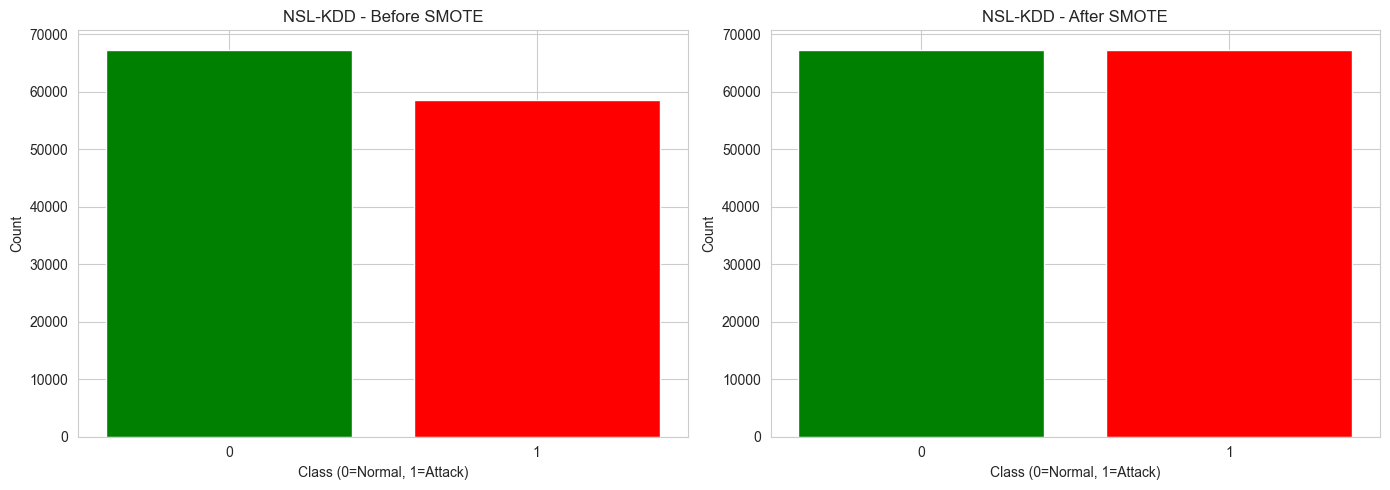


💾 Saving processed data to c:\Other files\GitHub\neural-sentinel\data\processed\nsl-kdd...
  ✅ All data saved successfully
📊 Loading UNSW-NB15 dataset...
  ✅ Train: 175,341 records
  ✅ Test: 82,332 records
  ✅ Features: 45

🚀 Processing UNSW-NB15 Dataset
  Initial shape: (175341, 45)
  Final shape: (175341, 45)
  📉 Removed: 0 rows
  Initial shape: (82332, 45)
  Final shape: (82332, 45)
  📉 Removed: 0 rows
  🔢 Encoding 4 categorical features...
  🔢 Encoding 4 categorical features...
  📊 Normalizing features...

⚖️  Applying Optimized SMOTE...
  Before SMOTE: Counter({np.int64(1): 119341, np.int64(0): 56000})
  After SMOTE: Counter({np.int64(0): 119341, np.int64(1): 119341})
  📈 Generated 63,341 synthetic samples

🔄 Creating sequences (window=10, stride=1)...
  ✅ Created 238,673 sequences
  Shape: (238673, 10, 44)

🔄 Creating sequences (window=10, stride=1)...
  ✅ Created 82,323 sequences
  Shape: (82323, 10, 44)

✅ UNSW-NB15 Preprocessing Complete
Training sequences: (238673, 10, 44)
T

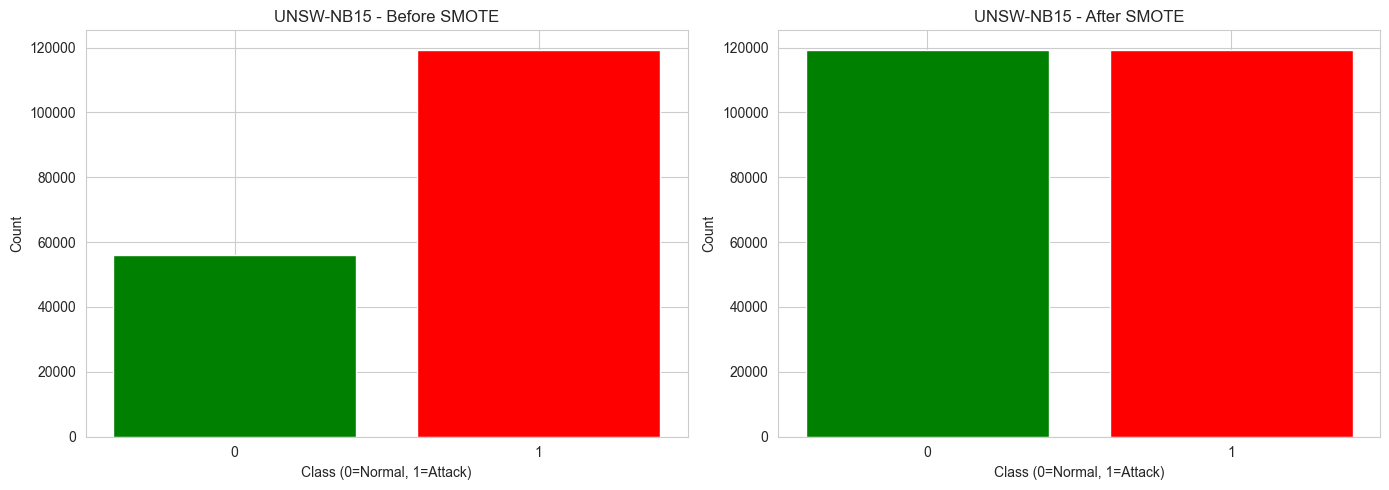


💾 Saving processed data to c:\Other files\GitHub\neural-sentinel\data\processed\unsw-nb15...
  ✅ All data saved successfully


In [53]:
# Load NSL-KDD
nsl_train, nsl_test = load_nsl_kdd(
    os.path.join(RAW_DATA_DIR, 'KDDTrain+.txt'),
    os.path.join(RAW_DATA_DIR, 'KDDTest+.txt')
)

# Process NSL-KDD
nsl_processed = preprocess_dataset(nsl_train, nsl_test, 'NSL-KDD', sequence_length=10)
save_processed_data(nsl_processed, 'NSL-KDD')

# Load UNSW-NB15
unsw_train, unsw_test = load_unsw_nb15(
    os.path.join(RAW_DATA_DIR, 'UNSW_NB15_training-set.csv'),
    os.path.join(RAW_DATA_DIR, 'UNSW_NB15_testing-set.csv')
)

# Process UNSW-NB15
unsw_processed = preprocess_dataset(unsw_train, unsw_test, 'UNSW-NB15', sequence_length=10)
save_processed_data(unsw_processed, 'UNSW-NB15')


Parameters to Fine-Tune 

1. Data Preprocessing Parameters

sequence_length = 10 (try: 5, 10, 15, 20)
stride = 1 (try: 1, 2, 5)
apply_smote = True/False
k_neighbors in SMOTE = 5 (try: 3, 5, 7)
2. LSTM Model Parameters

lstm_units = 64, 128, 256 (number of LSTM cells)
dropout_rate = 0.2, 0.3, 0.5 (prevents overfitting)
learning_rate = 0.001, 0.0001
batch_size = 32, 64, 128
epochs = 10, 20, 50
3. Optimization Parameters (for later AGLSTM)

population_size = 20, 50
max_iterations = 30, 50, 100